# Forward simulations 

In this notebook, we use a synthetic example to explore aspects of numerical modelling, including mesh design, as well as exploring aspects of the fundamental physics, including viewing the currents, charges and potentials from conductive and resistive targets. 

## Step 0: Imports and load survey

These steps are the same as in the previous notebook. 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# linear solvers
try: 
    from pymatsolver import Pardiso as Solver  # this is a fast linear solver 
except ImportError:
    from SimPEG import SolverLU as Solver  # this will be slower

# SimPEG inversion machinery
from SimPEG import (
    Data, maps,
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives
) 

# DC resistivity and IP modules
from SimPEG.electromagnetics import resistivity as dc
from SimPEG.electromagnetics import induced_polarization as ip

In [2]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 14

In [3]:
line = "46800E"

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

In [4]:
def read_dcip_data(filename, verbose=True):
    """
    Read in a .OBS file from the Century data set into a python dictionary. 
    The format is the old UBC-GIF DCIP format.
    
    Parameters
    ----------
    filename : str
        Path to the file to be parsed
    
    verbose: bool
        Print some things? 
    
    
    Returns
    -------
    dict
        A dictionary with the locations of
        - a_locations: the positive source electrode locations (numpy array) 
        - b_locations: the negative source electrode locations (numpy array) 
        - m_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - n_locations: the receiver locations (list of numpy arrays)
        - observed_data: observed data (list of numpy arrays)
        - standard_deviations: assigned standard deviations (list of numpy arrays)
        - n_sources: number of sources (int)
    
    """
    
    # read in the text file as a numpy array of strings (each row is an entry)
    contents = np.genfromtxt(filename, delimiter=' \n', dtype=np.str)
    
    # the second line has the number of sources, current, and data type (voltages if 1)
    n_sources = int(contents[1].split()[0])
    
    if verbose is True: 
        print(f"number of sources: {n_sources}")
    
    # initialize storage for the electrode locations and data
    a_locations = np.zeros(n_sources)
    b_locations = np.zeros(n_sources)
    m_locations = []
    n_locations = []
    observed_data = []
    standard_deviations = []
    
    # index to track where we have read in content 
    content_index = 1 
    
    # loop over sources 
    for i in range(n_sources):
        # start by reading in the source info 
        content_index = content_index + 1  # read the next line
        a_location, b_location, nrx = contents[content_index].split()  # this is a string

        # convert the strings to a float for locations and an int for the number of receivers
        a_locations[i] = float(a_location)
        b_locations[i] = float(b_location)
        nrx = int(nrx)

        if verbose is True: 
            print(f"Source {i}: A-loc: {a_location}, B-loc: {b_location}, N receivers: {nrx}")

        # initialize space for receiver locations, observed data associated with this source
        m_locations_i, n_locations_i = np.zeros(nrx), np.zeros(nrx)
        observed_data_i, standard_deviations_i = np.zeros(nrx), np.zeros(nrx)

        # read in the receiver info 
        for j in range(nrx):
            content_index = content_index + 1  # read the next line
            m_location, n_location, datum, std = contents[content_index].split()

            # convert the locations and data to floats, and store them
            m_locations_i[j] = float(m_location)
            n_locations_i[j] = float(n_location)
            observed_data_i[j] = float(datum)
            standard_deviations_i[j] = float(std)

        # append the receiver info to the lists
        m_locations.append(m_locations_i)
        n_locations.append(n_locations_i)
        observed_data.append(observed_data_i)
        standard_deviations.append(standard_deviations_i)
    
    return {
        "a_locations": a_locations,
        "b_locations": b_locations, 
        "m_locations": m_locations,
        "n_locations": n_locations,
        "observed_data": observed_data, 
        "standard_deviations": standard_deviations,
        "n_sources": n_sources, 
    }

In [5]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=False)

In [6]:
# initialize an empty list for each 
source_list = []

# center the survey and work in local coordinates
x_local = 0.5*(np.min(dc_data_dict["a_locations"]) + np.max(np.hstack(dc_data_dict["n_locations"])))

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i] - x_local, 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i] - x_local,
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i] - x_local, 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i] - x_local, 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [7]:
survey = dc.Survey(source_list=source_list)

# TODO: app for exploring forward simulation setup and impact on accuracy

parameters:
- n_cells_per_spacing_x
- n_cells_per_spacing_z
- n_core_extra_x, z
- npad_x, npad_z
- padding factor
- nky

In [8]:
def build_mesh(
    survey=survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
):
    """
    A function for designing a Tensor Mesh based on DC survey parameters
    
    Parameters
    ----------
    
    survey: dc.Survey 
        A DC (or IP) survey object
    
    n_cells_per_spacing_[x, z]: int
        Number of [x, z]-cells per the minimum electrode spacing
        
    n_core_extra_[x, z]: int
        Number of extra cells with the same size as the core domain beyond the survey extent
    
    core_domain_z_ratio: float
        Factor that multiplies the maximum AB, MN seperation to define the core mesh extent
    
    padding_factor: float
        Factor by which we expand the mesh cells in the padding region
    
    n_pad_[x, z]: int
        Number of padding cells in the x, z directions
    """
    min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))

    dx = min_electrode_spacing / n_cells_per_spacing_x
    dz = min_electrode_spacing / n_cells_per_spacing_z
    
    # define the x core domain
    core_domain_x = np.r_[
        survey.electrode_locations[:, 0].min(),
        survey.electrode_locations[:, 0].max()
    ]
    
    # find the y core domain
    # find the maximum spacing between source, receiver midpoints
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    seperation_ab_mn = np.abs(mid_ab - mid_mn)
    max_seperation = seperation_ab_mn.max()
    core_domain_z = np.r_[-core_domain_z_ratio * max_seperation, 0.]
    
    # add extra cells beyond the core domain
    n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra_x*2  # on each side
    n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra_z  # just below
    
    # define the tensors in each dimension
    hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
    hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

    mesh = discretize.TensorMesh([hx, hz], x0="CN")

    return mesh, core_domain_x, core_domain_z

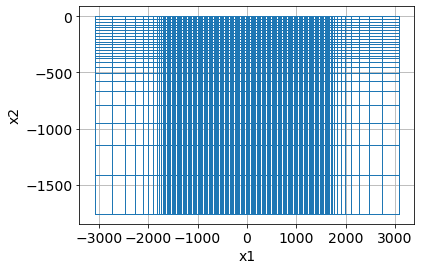

In [9]:
mesh, core_domain_x, core_domain_z = build_mesh(survey)
mesh.plotGrid()

In [10]:
mesh

TensorMesh: 3,900 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    156     -3,085.13      3,085.13     25.00    344.65    1.30
   y     25     -1,760.13         -0.00     25.00    344.65    1.30

In [11]:
def forward_simulation_halfspace(mesh, survey=survey, resistivity=100, nky=11):
    """
    A function that  returns predicted data given a mesh, survey, resistivity value
    """
    
    rho = resistivity * np.ones(mesh.nC)
    simulation_dc = dc.Simulation2DNodal(
        mesh, rhoMap=maps.IdentityMap(mesh), solver=Solver, 
        survey=survey, nky=nky
    )
    
    return simulation_dc.make_synthetic_data(rho)

In [23]:
def plot_apparent_resistivities(dpred):
    # plot psuedosection
    fig = plt.figure(constrained_layout=True, figsize=(12, 4))
    gs = fig.add_gridspec(ncols=3, nrows=1)

    ax0 = fig.add_subplot(gs[:2])
    ax1 = fig.add_subplot(gs[2])

    # plot the pseudosection 
    dc.utils.plot_pseudosection(
        dpred, data_type="apparent resistivity", # clim=clim,
        plot_type="pcolor", data_location=True, ax=ax0, 
    )
    ax0.set_aspect(2)  # some vertical exxageration
    ax0.set_title(f"{line} Pseudosection")
    ax0.set_xlabel("Northing (m)")

    # plot the errors in apparent resistivity relative to separation
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    seperation_ab_mn = np.abs(mid_ab - mid_mn)
    apparent_resistivity = dc.utils.apparent_resistivity(dpred)
    percent_error = (apparent_resistivity - halfspace_resistivity)/halfspace_resistivity*100

    ax1.plot(seperation_ab_mn[:, 0], percent_error, '.', alpha=0.4)
    ax1.set_xlabel("AB - MN seperation")
    ax1.set_ylabel("percent difference (%)")
    ax1.set_title("Error in apparent resistivities")
    # ax1.set_ylim(10*np.r_[-1, 1])
    ax1.grid(alpha=0.3)


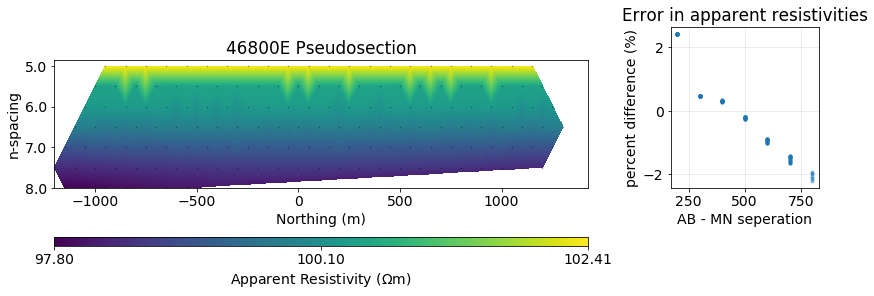

In [24]:
halfspace_resistivity = 100
dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity)
plot_apparent_resistivities(dpred)

In [25]:
def mesh_design_simulator(
    survey=survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
    halfspace_resistivity=100,
):
    mesh, core_domain_x, core_domain_z = build_mesh(
        survey=survey, 
        n_cells_per_spacing_x=n_cells_per_spacing_x,
        n_cells_per_spacing_z=n_cells_per_spacing_z,
        n_core_extra_x=n_core_extra_x,
        n_core_extra_z=n_core_extra_z,
        core_domain_z_ratio=core_domain_z_ratio,
        padding_factor=padding_factor,
        n_pad_x=n_pad_x,
        n_pad_z=n_pad_z,
    )
    dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity)
    plot_apparent_resistivities(dpred)

In [28]:
mesh_design_app = ipywidgets.interactive(
    mesh_design_simulator,
    survey=ipywidgets.fixed(survey),
    n_cells_per_spacing_x=ipywidgets.IntSlider(min=1, max=10, value=4, continuous_update=False),
    n_cells_per_spacing_z=ipywidgets.IntSlider(min=1, max=10, value=4, continuous_update=False),
    n_core_extra_x=ipywidgets.IntSlider(min=0, max=10, value=4, continuous_update=False),
    n_core_extra_z=ipywidgets.IntSlider(min=0, max=10, value=4, continuous_update=False),
    core_domain_z_ratio=ipywidgets.FloatSlider(min=0.1, max=1, value=0.3, continuous_update=False),
    padding_factor=ipywidgets.FloatSlider(min=1, max=2, value=1.3, continuous_update=False),
    n_pad_x=ipywidgets.IntSlider(min=1, max=20, value=10, continuous_update=False),
    n_pad_z=ipywidgets.IntSlider(min=1, max=20, value=10, continuous_update=False),
    halfspace_resistivity=ipywidgets.FloatLogSlider(min=0, max=5, value=2, continuous_update=False),
)

In [29]:
mesh_design_app

interactive(children=(IntSlider(value=4, continuous_update=False, description='n_cells_per_spacing_x', max=10,…

# TODO build up an example for visualizing currents, charges, electric fields, potentials

In [14]:
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

xlim_resistive_block = np.r_[-1000, -500]
ylim_resistive_block = np.r_[-200, -50]

xlim_conductive_block = np.r_[500, 1000]
ylim_conductive_block = np.r_[-200, -50]

### put the model on the mesh

In [15]:
rho = rho_background * np.ones(mesh.nC)

# resistive block
inds_resistive_block = (
    (mesh.gridCC[:, 0] >= xlim_resistive_block.min()) & (mesh.gridCC[:, 0] <= xlim_resistive_block.max()) &
    (mesh.gridCC[:, 1] >= ylim_resistive_block.min()) & (mesh.gridCC[:, 1] <= ylim_resistive_block.max())
)

rho[inds_resistive_block] = rho_resistive_block

# conductive block
inds_conductive_block = (
    (mesh.gridCC[:, 0] >= xlim_conductive_block.min()) & (mesh.gridCC[:, 0] <= xlim_conductive_block.max()) &
    (mesh.gridCC[:, 1] >= ylim_conductive_block.min()) & (mesh.gridCC[:, 1] <= ylim_conductive_block.max())
)

rho[inds_conductive_block] = rho_conductive_block

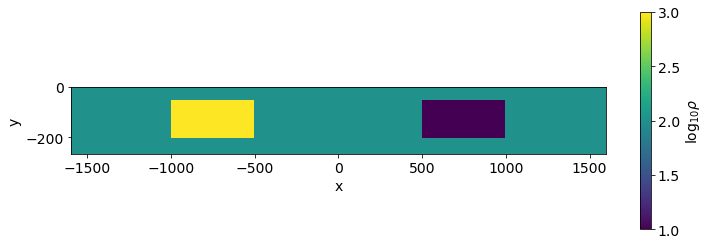

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
out = mesh.plotImage(np.log10(rho), ax=ax)
plt.colorbar(out[0], ax=ax, label="log$_{10} \\rho$")
ax.set_xlim(core_domain_x)
ax.set_ylim(core_domain_z)
ax.set_aspect(1.5)

In [17]:
# forward simulation 
# Use Exponential Map: m = log(rho)
mapping = maps.ExpMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey
)

In [18]:
%%time 

# run the forward simulation over the half-space & plot apparent resistivities
model = np.ones(mesh.nC) * np.log(rho)
synthetic_data = simulation_dc.make_synthetic_data(model)

CPU times: user 667 ms, sys: 43.2 ms, total: 710 ms
Wall time: 194 ms


Text(0.5, 0, 'Northing (m)')

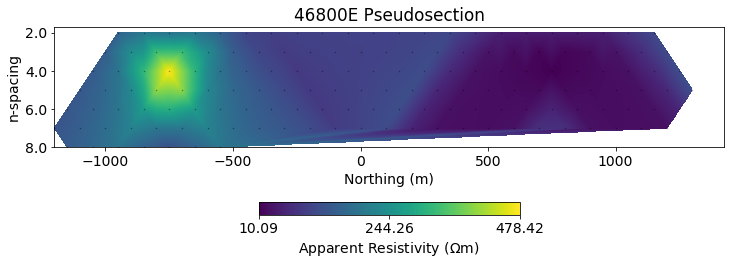

In [19]:
# plot psuedosection
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

dc.utils.plot_pseudosection(
    synthetic_data, data_type="apparent resistivity", # clim=clim,
    plot_type="pcolor", data_location=True, ax=ax, 
    cbar_opts={"pad":0.25}
)
ax.set_aspect(1.5)  # some vertical exxageration
ax.set_title(f"{line} Pseudosection")
ax.set_xlabel("Northing (m)")


In [20]:
# develop an app for the fields object

In [21]:
# save the data object with synthetic data

In [22]:
# move on to the next notebook 